<a href="https://colab.research.google.com/github/YakupTopaloglu/Speaker-Diarization/blob/main/CNN_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
import numpy as np
import librosa
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import matplotlib.pyplot as plt
import librosa.display
from sklearn.model_selection import train_test_split


In [ ]:

# Veri klasörü yolu
dataset_path = "/content/drive/MyDrive/HACIVAT&KARAGOZ/MODEL EĞİTİMİ/DATASET_20_VID"
import os
import numpy as np
import librosa
from sklearn.model_selection import train_test_split

def load_wav_and_extract_features(file_path, num_mfcc=40, max_len=50):
    """ WAV dosyasını yükleyip MFCC çıkaran fonksiyon """
    signal, sr = librosa.load(file_path, sr=16000)
    mfcc = librosa.feature.mfcc(y=signal, sr=sr, n_mfcc=num_mfcc)

    # MFCC'yi sabit uzunluğa getir
    if mfcc.shape[1] < max_len:
        pad_width = max_len - mfcc.shape[1]
        mfcc = np.pad(mfcc, ((0, 0), (0, pad_width)), mode='constant')
    else:
        mfcc = mfcc[:, :max_len]

    return mfcc

def create_dataset(data_dir):

    X, y = [], []
    class_names = sorted(os.listdir(data_dir))
    label_map = {name: idx for idx, name in enumerate(class_names)}

    for label_name in class_names:
        folder_path = os.path.join(data_dir, label_name)
        if not os.path.isdir(folder_path):
            continue
        for file in os.listdir(folder_path):
            if file.endswith('.wav'):
                file_path = os.path.join(folder_path, file)
                features = load_wav_and_extract_features(file_path)
                X.append(features)
                y.append(label_map[label_name])

    return np.array(X), np.array(y), class_names

# Veri Seti Yükleme
X, y, class_names = create_dataset(dataset_path)

# Veri Bölme (%80 Eğitim, %10 Validation, %10 Test)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.6, random_state=42)

# Çıktılar
print("Veri Seti Boyutu:", X.shape)
print("Eğitim Kümesi:", X_train.shape, y_train.shape)
print("Validation Kümesi:", X_val.shape, y_val.shape)
print("Test Kümesi:", X_test.shape, y_test.shape)
print("Sınıf İsimleri:", class_names)


Veri Seti Boyutu: (4389, 40, 50)
Eğitim Kümesi: (2633, 40, 50) (2633,)
Validation Kümesi: (702, 40, 50) (702,)
Test Kümesi: (1054, 40, 50) (1054,)
Sınıf İsimleri: ['HACIVAT', 'INSTRUMENTS', 'KARAGOZ', 'OTHERS']


In [ ]:
num_classes = len(class_names)
model = tf.keras.Sequential([

    tf.keras.layers.Reshape((40, 50, 1), input_shape=(40, 50)),
    tf.keras.layers.Conv2D(32, kernel_size=(3,3), activation='relu', padding="same"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(pool_size=(2,2)),
    tf.keras.layers.Conv2D(64, kernel_size=(3,3), activation='relu', padding="same"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(pool_size=(2,2)),
    tf.keras.layers.Conv2D(128, kernel_size=(3,3), activation='relu', padding="same"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(pool_size=(2,2)),


    tf.keras.layers.Reshape((10, -1)),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.LSTM(64, return_sequences=False),
    tf.keras.layers.Dense(32, activation='relu'),

    tf.keras.layers.Dropout(0.3),  # Overfitting önlemek için

    tf.keras.layers.Dense(len(class_names), activation='softmax')
])

model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ reshape (Reshape)               │ (None, 40, 50, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 40, 50, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 40, 50, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 20, 25, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 20, 25, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 20, 25, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 10, 12, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 10, 12, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 10, 12, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 5, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_1 (Reshape)             │ (None, 10, 384)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 10, 128)        │        49,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 4)              │           132 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 194,468 (759.64 KB)

 Trainable params: 194,020 (757.89 KB)

 Non-trainable params: 448 (1.75 KB)

In [ ]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=20,
    batch_size=16,
    shuffle=True
)

Epoch 1/20
165/165 ━━━━━━━━━━━━━━━━━━━━ 11s 20ms/step - accuracy: 0.6629 - loss: 0.7673 - val_accuracy: 0.8048 - val_loss: 0.4900
Epoch 2/20
165/165 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8634 - loss: 0.3837 - val_accuracy: 0.8746 - val_loss: 0.3588
Epoch 3/20
165/165 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.8954 - loss: 0.3001 - val_accuracy: 0.9117 - val_loss: 0.2526
Epoch 4/20
165/165 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.9131 - loss: 0.2725 - val_accuracy: 0.8647 - val_loss: 0.3526
Epoch 5/20
165/165 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9176 - loss: 0.2555 - val_accuracy: 0.8989 - val_loss: 0.3255
Epoch 6/20
165/165 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.9215 - loss: 0.2365 - val_accuracy: 0.9245 - val_loss: 0.2233
Epoch 7/20
165/165 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.9538 - loss: 0.1547 - val_accuracy: 0.9088 - val_loss: 0.2775
Epoch 8/20
165/165 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.9439 - loss: 0.1716 - val_acc

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9353 - loss: 0.2501

Test Loss: 0.2545
Test Accuracy: 93.26%
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step


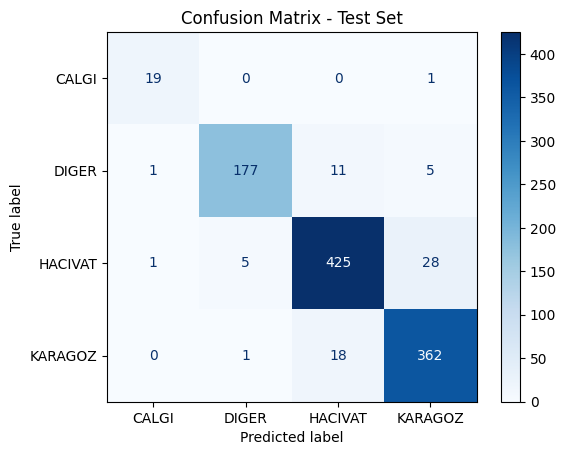


Classification Report:

              precision    recall  f1-score   support

       CALGI       0.90      0.95      0.93        20
       DIGER       0.97      0.91      0.94       194
     HACIVAT       0.94      0.93      0.93       459
     KARAGOZ       0.91      0.95      0.93       381

    accuracy                           0.93      1054
   macro avg       0.93      0.93      0.93      1054
weighted avg       0.93      0.93      0.93      1054



In [ ]:
# Test seti değerlendirme
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"\nTest Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

# Test verisinde tahmin yap
y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)

# Confusion matrix oluştur
cm = confusion_matrix(y_test, y_pred)

# Confusion matrix görselleştir
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix - Test Set")
plt.show()

# Classification report (Precision, Recall, F1)
print("\nClassification Report:\n")
print(classification_report(y_test, y_pred, target_names=class_name))

In [ ]:
# Modeli kaydet
model.save("karagoz_hacivat_cnn_model.h5")

# Örnek test
sample = X_test[0:1]
prediction = model.predict(sample)
predicted_label = np.argmax(prediction, axis=1)

print(f"Gerçek sınıf: {class_names[y_test[0]]}")
print(f"Tahmin edilen sınıf: {class_names[predicted_label[0]]}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
Gerçek sınıf: HACIVAT
Tahmin edilen sınıf: HACIVAT


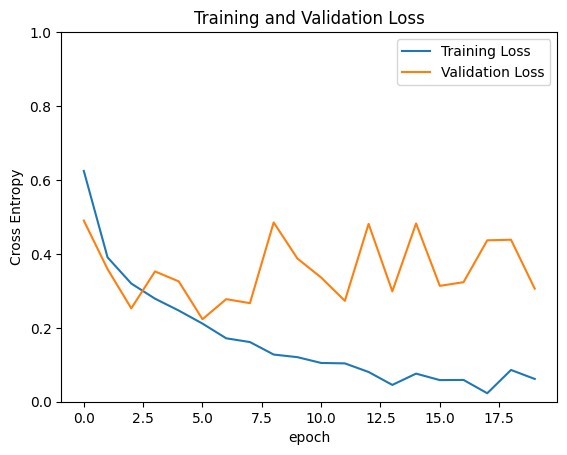

In [ ]:
loss =history.history['loss']
val_loss = history.history['val_loss']
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()